# Incompressible Fluid - Navier-Stokes 2D - Staggered Grids

ME469 - Computational Methods in Fluid Dynamics - Stanford University


These examples are provided as part of the ME469 class (Winter 2020).

For comments or corrections, please contact jops at stanford dot edu

## Objective
Solution of the Navier-Stokes equations using staggered grid formulation and a control volume approach.

$$ \int_S \rho \left(\vec{v} \cdot \hat{n} \right) dS = 0 $$
$$ \frac{d}{dt} \int_{\Omega} \rho u_i d\Omega + \int_S \rho u_i (\vec{v} \cdot \hat{n}) dS = \int_S \tau_{ij} \left( \hat{i}_j \cdot \hat{n} \right) dS - \int_S p \left( \hat{i}_i \cdot \hat{n} \right) dS
$$

where $S$ is the surface of the control volume, $V$ its volume and $\tau$ is the viscous stress tensor. Boundary conditions are specified as slip walls on all boundaries, with a fixed tangential velocity.

The procedure for the projection method (with explicit time treatment for the velocities) is:

1. calculate an intermediate velocity u* field without the pressure gradient
2. calculate the divergence of the velocity field, this term will be the right hand side of the Poisson equation for the pressure
3. discretize the Poisson equation for the pressure (trivial for constant density)
4. solve the poisson equation iteratively
5. correct the velocities (explicitly) with the pressure gradient
6. go to the next timestep

Personal notes:

1. The linear solvers have the discretization of the RHS of the Poisson system inside them = > not reusable???
2. Pressure is solved for in one step, and used to correct velocity

In [2]:
#set things up
import numpy  as np                       
import time, sys  
import matplotlib.pyplot as pl
from matplotlib import cm
from scipy.interpolate import make_interp_spline, BSpline
%matplotlib inline 

### Let's get started
Set physical and computational parameter for the problem, i.e. the diffusion coefficient.
We assume a uniform grid in x&y in the unit square [0:1]x[0:1];
Boundary velocity on the cavity sides are defined as slip-wall (tangential components): ubc_south, ubc_north, vbc_west, vbc_east

In [3]:
mu      = 0.1      # diffusion coefficient [m^2/s]
deltat  = 0.02     # time step (stability limit checked later)

 The mass/pressure CV is located at  (jcv,icv), the x-velocity CV is located at (jcv,ino), the y-velocity CV is located at (jno,icv).

The functions below enable the solution of the Poisson system for pressure using Gauss-Seidel or the Incomplete LU decomposition method of Stone.

In [4]:
# solve a linear system using gauss-seidel
def solve_gs(ncv_x,ncv_y,dx,dy,phi,a_east,a_west,a_north,a_south,a_p,b,n_iter,tolerance):
    
    res = np.zeros((ncv_y,ncv_x))               #initialize

    for n in range(n_iter):
        # update solution - internal cells
        for jcv in range(ncv_y):
            jcv_north = min(jcv+1,ncv_y-1)      # assumes a_north[ncv_y-1,icv]=0
            jcv_south = max(jcv-1,0)            # assumes a_south[0,icv]=0
            for icv in range(ncv_x):
                icv_east = min(icv+1,ncv_x-1)   # assumes a_east[jcv,ncv_x-1]=0
                icv_west = max(icv-1,0)         # assumes a_west[jcv,0]=0
                phi[jcv,icv]=(b[jcv,icv]
                          -a_east [jcv,icv]*phi[jcv,icv_east ]-a_west [jcv,icv]*phi[jcv,icv_west ] 
                          -a_north[jcv,icv]*phi[jcv_north,icv]-a_south[jcv,icv]*phi[jcv_south,icv])/a_p[jcv,icv]
                
        for jcv in range(ncv_y):
            jcv_north = min(jcv+1,ncv_y-1)      # assumes a_north[ncv_y-1,icv]=0
            icv_south = max(jcv-1,0)            # assumes a_south[0,icv]=0
            for icv in range(ncv_x):
                icv_east = min(icv+1,ncv_x-1)   # assumes a_east[jcv,ncv_x-1]=0
                icv_west = max(icv-1,0)         # assumes a_west[jcv,0]=0
                res[jcv,icv] = (b[jcv,icv]
                        -a_east [jcv,icv]*phi[jcv,icv_east ]-a_west [jcv,icv]*phi[jcv,icv_west ]
                        -a_north[jcv,icv]*phi[jcv_north,icv]-a_south[jcv,icv]*phi[jcv_south,icv]
                        -a_p[jcv,icv]*phi[jcv,icv])
                residual = np.sqrt(dx*dy*np.sum(res[0:ncv_y,0:ncv_x]**2))                     
        if (n == 0):
            residual0 = residual
        if residual/residual0 < tolerance:
            break
    print("Completed Gauss-Seidel Iteration ",n,"Residual ",residual/residual0)


# solve a linear system using ILU
def solve_ilu(ncv_x,ncv_y,dx,dy,phi,a_east,a_west,a_north,a_south,a_p,b,n_iter,tolerance):
    small = 1.0E-8
    alpha = 0.92 #under-relation factor...
    l_west  = np.zeros((ncv_y,ncv_x))
    l_south = np.zeros((ncv_y,ncv_x))
    l_p     = np.zeros((ncv_y,ncv_x))
    u_north = np.zeros((ncv_y,ncv_x))
    u_east  = np.zeros((ncv_y,ncv_x))
    res     = np.zeros((ncv_y,ncv_x))             
     
    # compute L/U coefficients
    
    for jcv in range(ncv_y):
        jcv_south = max(jcv-1,0) 
        for icv in range(ncv_x):
            icv_west = max(icv-1,0)         # assumes u_north[jcv,0]=0, a_west[jcv,0]=0 
            l_west [jcv,icv] = a_west [jcv,icv]/(1.+alpha*u_north[jcv,icv_west])
            l_south[jcv,icv] = a_south[jcv,icv]/(1.+alpha*u_east [jcv_south,icv] )
            p1 = alpha*l_west [jcv,icv]*u_north[jcv,icv_west]
            p2 = alpha*l_south[jcv,icv]*u_east [jcv_south,icv]            
            l_p [jcv,icv]    = (a_p[jcv,icv]+p1+p2 -l_west [jcv,icv]*u_east [jcv,icv_west]
                                                   -l_south[jcv,icv]*u_north[jcv_south,icv] )
            u_north[jcv,icv] = (a_north[jcv,icv]-p1)/(l_p[jcv,icv]+small)
            u_east [jcv,icv] = (a_east [jcv,icv]-p2)/(l_p[jcv,icv]+small)
    
    for n in range(n_iter+1):

        # compute residual
        residual = 0.0
        for jcv in range(ncv_y):
            jcv_north = min(jcv+1,ncv_y-1)      # assumes a_north[ncv_y-1,icv]=0
            jcv_south = max(jcv-1,0)            # assumes a_south[0,icv]=0
            for icv in range(ncv_x):
                icv_east = min(icv+1,ncv_x-1)   # assumes a_east[jcv,ncv_x-1]=0
                icv_west = max(icv-1,0)         # assumes a_west[jcv,0]=0
                res[jcv,icv]=(b[jcv,icv]
                            -a_east [jcv,icv]*phi[jcv,icv_east ]-a_west [jcv,icv]*phi[jcv,icv_west ]
                            -a_north[jcv,icv]*phi[jcv_north,icv]-a_south[jcv,icv]*phi[jcv_south,icv]
                            -a_p[jcv,icv]*phi[jcv,icv])
                residual=residual+res[jcv,icv]*res[jcv,icv]
                
                res[jcv,icv]=(res[jcv,icv]-l_south[jcv,icv]*res[jcv_south,icv]
                                          -l_west [jcv,icv]*res[jcv,icv_west] )/(l_p[jcv,icv]+small)  
    
        residual = np.sqrt(dx*dy*residual)
        if (n == 0):
            residual0 = residual
        
        # back-substitution
        for jcv in range(ncv_y-1,-1,-1):
            jcv_north = min(jcv+1,ncv_y-1)      # assumes a_north[ncv_y-1,icv]=0
            for icv in range(ncv_x-1,-1,-1):
                icv_east = min(icv+1,ncv_x-1)   # assumes a_east[jcv,ncv_x-1]=0
                res[jcv,icv]=res[jcv,icv]-u_north[jcv,icv]*res[jcv_north,icv]-u_east[jcv,icv]*res[jcv,icv_east]
                phi[jcv,icv]=phi[jcv,icv]+res[jcv,icv]
                
        #print "It",n,"residual",residual        
        if residual/residual0 < tolerance:
            break
    #if (n==n_iter):
    #    print "ILU achieved max iteration ",n,"Residual ",residual/residual0

Solution of the Poisson equation for pressure. Note that the matrix of coefficient is already filled and stored in diagonals.

In [5]:
# solve the Poisson equation for pressure  
def solve_p(ncv_x,ncv_y,nno_x,nno_y,h,dt,p,a_east,a_west,a_north,a_south,a_p,b,ut,vt,solver="ilu"):  

    #solve for the pressure 
    for jcv in range(ncv_y):
        jno_north =  jcv+1    
        jno_south =  jcv  
        for icv in range(ncv_x):        
            ino_east  =  icv+1 
            ino_west  =  icv 

            b[jcv,icv] = (h/dt)*( ut[jcv,ino_east]-ut[jcv,ino_west]+ 
                                  vt[jno_north,icv]-vt[jno_south,icv] )               # STEP 2: div(ut)
            p[jcv,icv] = 0.0                                                          # initial guess for p
     
    if (solver=="ilu"):
        solve_ilu(ncv_x,ncv_y,h,h,p,a_east,a_west,a_north,a_south,a_p,b,25,1.0E-5)
    else:
        solve_gs(ncv_x,ncv_y,h,h,p,a_east,a_west,a_north,a_south,a_p,b,25,1.0E-5)

        
def solve_uv(ncv_x,ncv_y,nno_x,nno_y,h,dt,ubc_south,ubc_north,vbc_west,vbc_east,u,v,ut,vt):
    
    # update the temporary x-velocity field (only internal u-cells)    
    for jcv in range(ncv_y): 
        for ino in range(1,nno_x-1):
            icv = ino
            jno = jcv
            
            # compute convective fluxes

            # compute x-velocity at the faces of the u-control volume &
            # compute y-velocity at the y-faces of the u-control volume
            uf_east  = 0.5 * (u[jcv,ino] + u[jcv,ino+1])
            uf_west  = 0.5 * (u[jcv,ino] + u[jcv,ino-1])
            if (jcv==0): # south boundary of the domain
                uf_south = ubc_south
                vf_south = 0.0  
                uf_north = 0.5 * (u[jcv,ino]   + u[jcv+1,ino])
                vf_north = 0.5 * (v[jno+1,icv] + v[jno+1,icv-1])
            elif (jcv==ncv_y-1): # north boundary of the domain
                uf_south = 0.5 * (u[jcv,ino]   + u[jcv-1,ino])
                vf_south = 0.5 * (v[jno,icv]   + v[jno,icv-1])
                uf_north = ubc_north
                vf_north = 0.0
            else:
                #print "jcv,ino",jcv,ino
                uf_south = 0.5 * (u[jcv,ino]   + u[jcv-1,ino])
                vf_south = 0.5 * (v[jno,icv]   + v[jno,icv-1])
                uf_north = 0.5 * (u[jcv,ino]   + u[jcv+1,ino])
                vf_north = 0.5 * (v[jno+1,icv] + v[jno+1,icv-1])
            
            # convective part of H
            F_c = (uf_east**2-uf_west**2+uf_north*vf_north-uf_south*vf_south)/h
                
            # compute diffusive fluxes
            ucv_east = u[jcv,ino+1]
            ucv_west = u[jcv,ino-1]
            if (jcv==0):  # south boundary of the domain
                ucv_south = 2.0 * ubc_south - u[jcv,ino] # extrapolating with u @ south boundary = 0
                ucv_north = u[jcv+1,ino]
            elif (jcv==ncv_y-1): # north boundary of the domain  u @ north boundary = u_lid
                ucv_south = u[jcv-1,ino]
                ucv_north = 2.0 * ubc_north - u[jcv,ino]
            else:
                ucv_south = u[jcv-1,ino]
                ucv_north = u[jcv+1,ino]
            
            # diffusive part of H - second order centred difference 
            F_d = (mu/(h**2))*(ucv_east+ucv_west+ucv_north+ucv_south-4.0*u[jcv,ino]) 
                
            # update the temporary velocity
            ut[jcv,ino] = u[jcv,ino] + dt * ( -F_c+F_d )                               # STEP 1: (ut,vt)
                
    # update the temporary y-velocity field (only internal v-cells)    
    for jno in range (1,nno_y-1): 
        for icv in range(ncv_x):
            ino = icv
            jcv = jno
            # compute convective fluxes

            # compute y-velocity at the faces of the v-control volume &
            # compute x-velocity at the x-faces of the v-control volume    
            vf_north  = 0.5 * (v[jno,icv] + v[jno+1,icv])
            vf_south  = 0.5 * (v[jno,icv] + v[jno-1,icv])
            if (icv==0): # west boundary of the domain
                uf_west = 0.0
                vf_west = vbc_west
                uf_east = 0.5 * (u[jcv,ino+1]+u[jcv-1,ino+1])
                vf_east = 0.5 * (v[jno,icv]+v[jno,icv+1])
            elif (icv==ncv_x-1): # east boundary of the domain
                uf_west = 0.5 * (u[jcv,ino]+u[jcv-1,ino])
                vf_west = 0.5 * (v[jno,icv]+v[jno,icv-1])
                uf_east = 0.0
                vf_east = vbc_east
            else:
                uf_west = 0.5 * (u[jcv,ino]+u[jcv-1,ino])
                vf_west = 0.5 * (v[jno,icv]+v[jno,icv-1])
                uf_east = 0.5 * (u[jcv,ino+1]+u[jcv-1,ino+1])
                vf_east = 0.5 * (v[jno,icv]+v[jno,icv+1])
            
            F_c = (vf_north**2-vf_south**2+uf_east*vf_east-uf_west*vf_west )/h

            # compute diffusive fluxes
            vcv_north = v[jno+1,icv]
            vcv_south = v[jno-1,icv]
            if (icv==0):  # west boundary of the domain
                vcv_west = 2.0*vbc_west - v[jno,icv] # extrapolating with v @ west boundary = 0
                vcv_east =   v[jno,icv+1]
            elif (icv==ncv_x-1): # north boundary of the domain
                vcv_west =   v[jno,icv-1]    
                vcv_east = 2.0*vbc_east - v[jno,icv] # extrapolating with v @ east boundary = 0
            else:
                vcv_west = v[jno,icv-1]
                vcv_east = v[jno,icv+1]
                    
            F_d = (mu/(h**2))*(vcv_east+vcv_west+vcv_north+vcv_south-4.0*v[jno,icv])
                
            # update the temporary velocity
            vt[jno,icv] = v[jno,icv] + dt * ( -F_c+F_d )
                
def correct_uv(ncv_x,ncv_y,nno_x,nno_y,h,dt,u,v,ut,vt,p):                         # STEP 5: compute u^n+1
    # correct (and update) the velocity for the internal cells
    for jcv in range(ncv_y): 
        for ino in range(1,nno_x-1):
            u[jcv,ino] = ut[jcv,ino] - (dt/h)*(p[jcv,ino]-p[jcv,ino-1])      #note the minus before grad(p)
    for jno in range (1,nno_y-1): 
        for icv in range(ncv_x):
            v[jno,icv] = vt[jno,icv] - (dt/h)*(p[jno,icv]-p[jno-1,icv])

def plot_uv(ncv_x,ncv_y,nno_x,nno_y,ubc_south,ubc_north,vbc_west,vbc_east,x,y,u,v):
    # interpolate velocity on nodes 
    u_plot = np.zeros((nno_y,nno_x)) 
    v_plot = np.zeros((nno_y,nno_x)) 
    vmag_plot = np.zeros((nno_y,nno_x))
    for jno in range(nno_y):
        u_plot[jno,0] = 0.0
        v_plot[jno,0] = vbc_west
        u_plot[jno,nno_x-1] = 0.0
        v_plot[jno,nno_x-1] = vbc_east
    for ino in range(1,nno_x-1):
        u_plot[0,ino] = ubc_south
        v_plot[0,ino] = 0.0
        u_plot[nno_y-1,ino] = ubc_north
        v_plot[nno_y-1,ino] = 0.0
    for jno in range(1,nno_y-1):
        for ino in range(1,nno_x-1):  
            u_plot[jno,ino] = 0.5*(u[jno,ino]+u[jno-1,ino])
            v_plot[jno,ino] = 0.5*(v[jno,ino]+v[jno,ino-1])
    # compute velocity magnitude
    for jno in range(nno_y):
        for ino in range(nno_x):  
            vmag_plot[jno,ino] = np.sqrt(u_plot[jno,ino]*u_plot[jno,ino]+v_plot[jno,ino]*v_plot[jno,ino])
   
    # plot vontours of velocity magnitude and velocity vectors
    X, Y = np.meshgrid(x, y)
    fig = pl.figure(figsize=(11, 7), dpi=100)
    pl.contourf(X, Y, vmag_plot, alpha=0.5, cmap=cm.viridis)
    pl.gca().set_aspect('equal')
    pl.colorbar()
    pl.contour(X, Y, vmag_plot, cmap=cm.viridis)
    pl.quiver(X , Y , u_plot , v_plot )
    pl.xlabel('X')
    pl.ylabel('Y');
    
def compute_tau(ncv_x,ncv_y,nno_x,nno_y,h,ubc_south,ubc_north,vbc_west,vbc_east,u,v):
    # compute total friction on all walls
    tau_south = 0.0
    tau_north = 0.0
    tau_east = 0.0
    tau_west = 0.0
    for ino in range(1,nno_x-1):
        tau = mu*(u[0,ino]-ubc_south)/(0.5*h)
        tau_south = tau_south+tau*h
        tau = mu*(ubc_north-u[ncv_y-1,ino])/(0.5*h)
        tau_north = tau_north+tau*h
    for jno in range(1,nno_y-1):
        tau = mu*(v[jno,0]-vbc_west)/(0.5*h)
        tau_west = tau_west+tau*h
        tau = mu*(vbc_east-v[jno,ncv_x-1])/(0.5*h)
        tau_east = tau_east+tau*h
    #print("Friction S/N/W/E",tau_south,tau_north,tau_west,tau_east)    
    #print("Friction E:",tau_east)
    return tau_east

In [6]:
# solve the Navier-Stokes Equations
def solve(ncv,ubc_south,ubc_north,vbc_west,vbc_east,solver="ilu",plot=1):  
    
    #assume uniform grid in x&y in the unit square [0:1]x[0:1]
    ncv_x   = ncv                   #input to the solver
    ncv_y   = ncv_x
    
    # define grid
    nno_x   = ncv_x + 1
    nno_y   = ncv_y + 1

    # initialize
    u       = np.zeros((ncv_y,nno_x))  
    v       = np.zeros((nno_y,ncv_x)) 
    p       = np.zeros((ncv_y,ncv_x)) 
    ut      = np.zeros((ncv_y,nno_x)) #temporary velocity field
    vt      = np.zeros((nno_y,ncv_x)) 

    # time step and grid size
    h       = 1.0/ncv_x
    vmax = max(abs(ubc_north),abs(ubc_south),abs(vbc_west),abs(vbc_east))
    # check stability limit
    dt      = deltat              # defaults to 0.02
    dt      = min(dt,.2*h*h/mu)   # viscous limit
    dt      = min(dt,2.0*mu/vmax) # Peclet number limit

    # grid points (nodes)
    x       = np.linspace(0.0,1.0,nno_x)
    y       = np.linspace(0.0,1.0,nno_y)

    # initialize the matrix of coefficient                                         # STEP 3: Poisson disc.
    a_east  = np.zeros((ncv_y,ncv_x))       #
    a_west  = np.zeros((ncv_y,ncv_x))       #
    a_north = np.zeros((ncv_y,ncv_x))       ### pentadiagonal LHS of Poisson solver (holds lap(p) coeffs.)
    a_south = np.zeros((ncv_y,ncv_x))       #
    a_p     = np.zeros((ncv_y,ncv_x))       #
    b       = np.zeros((ncv_y,ncv_x))       #will hold div(ut) at each cell center for Poisson solver RHS
    phi     = np.zeros((ncv_y,ncv_x)) 

    # build the matrix for the pressure equation
    for jcv in range(ncv_y):
        for icv in range(ncv_x): 
            if (jcv>0):
                a_south[jcv,icv] = 1.0
            if (jcv<ncv_y-1):
                a_north[jcv,icv] = 1.0
            if (icv>0):
                a_west[jcv,icv] = 1.0
            if (icv<ncv_x-1):
                a_east[jcv,icv] = 1.0
            a_p[jcv,icv] = -(a_north[jcv,icv]+a_south[jcv,icv]+a_east[jcv,icv]+a_west[jcv,icv])

    # time loop
    totalTime = 0.31 #approximate steady state
    timesteps = round(totalTime/dt)
    
    time = 0.0
    for istep in range(timesteps):
        #update the temporary velocity field (advance u and v to ut and vt - the star fields w/o continuity)
        solve_uv(ncv_x,ncv_y,nno_x,nno_y,h,dt,ubc_south,ubc_north,vbc_west,vbc_east,u,v,ut,vt)
        
        #compute the pressure field                                                 # STEP 4: Poisson solve
        solve_p(ncv_x,ncv_y,nno_x,nno_y,h,dt,p,a_east,a_west,a_north,a_south,a_p,b,ut,vt,"ilu")
        #correct the velocity field
        
        correct_uv(ncv_x,ncv_y,nno_x,nno_y,h,dt,u,v,ut,vt,p) 
        # advance time
        time = time+dt                                                              # STEP 6: Integrate time
        
    if plot:
        # plot results reporting velocity on all nodes (average)
        plot_uv(ncv_x,ncv_y,nno_x,nno_y,ubc_south,ubc_north,vbc_west,vbc_east,x,y,u,v)
    #compute and write skin friction
    tau_east = compute_tau(ncv_x,ncv_y,nno_x,nno_y,h,ubc_south,ubc_north,vbc_west,vbc_east,u,v)
    #print("\nFinal time:",time,"seconds")
    return tau_east

0.36955310132488617

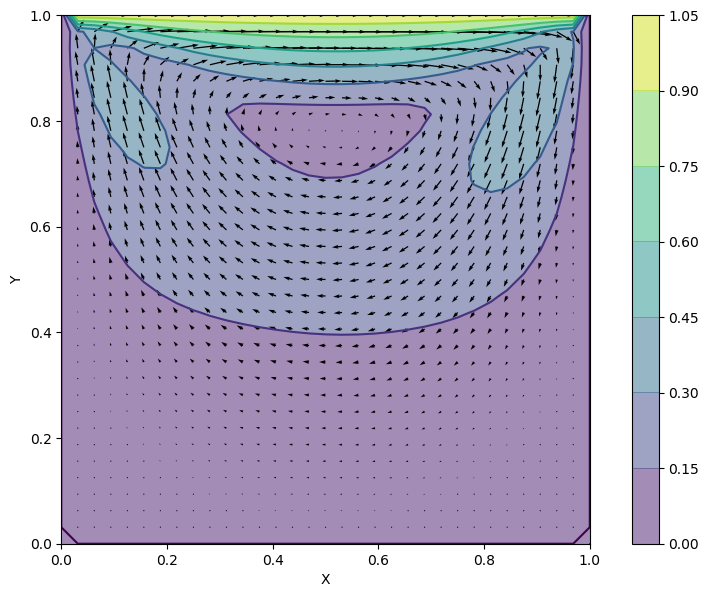

In [7]:
solve(32,0.0,1.0,0.0,0.0,"ilu",1) #note: ~64 grid points is when it starts to take a while

In [8]:
# grid convergence
# monitor friction coefficient on East wall (tau_east) with successive refinements

def converge(levels):
    tau      = np.zeros(levels)
    
    for i in range(levels):
        tau[i] = solve(4*(2**i),0.0,1.0,0.0,0.0,"ilu",0)  
    error    = (tau[1:] - tau[0:-1])/tau[1:]*100  #relative error in tau_east

    l        = np.linspace(1,levels-1,levels-1)
    lSpl     = np.linspace(1,len(l),300)
    spl      = make_interp_spline(l, error, k=2)  # smooth out curve with a b-spline
    errorSpl = spl(lSpl)
    fig1 = pl.figure(figsize=(4,3), dpi=100)
    pl.plot(lSpl, errorSpl)
    pl.xlabel('number of CVs')
    pl.ylabel('% error in east wall friction')
    pl.tick_params(
        axis='x',          
        which='both',      
        bottom=False,      
        top=False)
    pl.xticks([], [])
    return error

array([60.44707075, 36.10096232, 26.14212789, 20.53297514, 16.92802617])

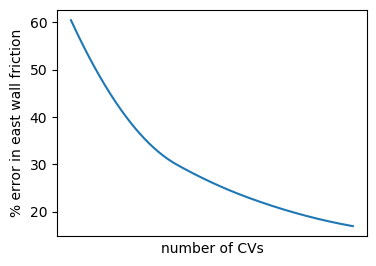

In [9]:
converge(6) #input number of levels of refinement starting at 4x4